# Sentiment Analysis
In this notebook we will:-
- prepare the review text data
- use Bag of Words model to prepare train and test 
- develop and train MLP(multi-layer perceptron) and use it to make prediction

### Movie Review Dataset
 - http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz
 
 contains 1000 positive and 1000 negative reviews

In [8]:
from nltk.corpus import stopwords
import string
import re
import os
from collections import Counter

## Load and clean and save tokens

### Cleaning Steps:
- split by spaces
- remove punctuations
- remove words that are not alphabetic
- remove stopwords and tokens with length 1

### saving tokens
- load pos and neg sentiments docs and process the docs
- make a vocab from all docs and save it

In [2]:
def load_doc(file):
    with open(file, 'r') as f:
        text = f.read()
    return text

def clean_doc(text):
    tokens = text.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    stops = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stops and len(w)>1]
    return tokens

In [4]:
# test load_doc and clean_doc
filename = 'review_polarity/txt_sentoken/pos/cv000_29590.txt'
text = load_doc(filename)
tokens = clean_doc(text)
tokens

['films',
 'adapted',
 'comic',
 'books',
 'plenty',
 'success',
 'whether',
 'theyre',
 'superheroes',
 'batman',
 'superman',
 'spawn',
 'geared',
 'toward',
 'kids',
 'casper',
 'arthouse',
 'crowd',
 'ghost',
 'world',
 'theres',
 'never',
 'really',
 'comic',
 'book',
 'like',
 'hell',
 'starters',
 'created',
 'alan',
 'moore',
 'eddie',
 'campbell',
 'brought',
 'medium',
 'whole',
 'new',
 'level',
 'mid',
 'series',
 'called',
 'watchmen',
 'say',
 'moore',
 'campbell',
 'thoroughly',
 'researched',
 'subject',
 'jack',
 'ripper',
 'would',
 'like',
 'saying',
 'michael',
 'jackson',
 'starting',
 'look',
 'little',
 'odd',
 'book',
 'graphic',
 'novel',
 'pages',
 'long',
 'includes',
 'nearly',
 'consist',
 'nothing',
 'footnotes',
 'words',
 'dont',
 'dismiss',
 'film',
 'source',
 'get',
 'past',
 'whole',
 'comic',
 'book',
 'thing',
 'might',
 'find',
 'another',
 'stumbling',
 'block',
 'hells',
 'directors',
 'albert',
 'allen',
 'hughes',
 'getting',
 'hughes',
 'brot

In [5]:
def add_doc_to_vocab(file, vocab):
    text = load_doc(file)
    tokens = clean_doc(text)
    vocab.update(tokens)
    
def process_docs(folder, vocab):
    for filename in os.listdir(folder):
        if filename.startswith('cv9'):
            continue
        path = folder + "/" + filename
        add_doc_to_vocab(path, vocab)

In [9]:
# test add_doc_to_vocab and process_docs
vocab = Counter()
process_docs("review_polarity/txt_sentoken/pos", vocab)
process_docs("review_polarity/txt_sentoken/neg", vocab)
print("Length of vocab is :",len(vocab))
print("Most common 50 tokens are: ",vocab.most_common(50))

Length of vocab is : 44276
Most common 50 tokens are:  [('film', 7983), ('one', 4946), ('movie', 4826), ('like', 3201), ('even', 2262), ('good', 2080), ('time', 2041), ('story', 1907), ('films', 1873), ('would', 1844), ('much', 1824), ('also', 1757), ('characters', 1735), ('get', 1724), ('character', 1703), ('two', 1643), ('first', 1588), ('see', 1557), ('way', 1515), ('well', 1511), ('make', 1418), ('really', 1407), ('little', 1351), ('life', 1334), ('plot', 1288), ('people', 1269), ('could', 1248), ('bad', 1248), ('scene', 1241), ('movies', 1238), ('never', 1201), ('best', 1179), ('new', 1140), ('scenes', 1135), ('man', 1131), ('many', 1130), ('doesnt', 1118), ('know', 1092), ('dont', 1086), ('hes', 1024), ('great', 1014), ('another', 992), ('action', 985), ('love', 977), ('us', 967), ('go', 952), ('director', 948), ('end', 946), ('something', 945), ('still', 936)]


In [14]:
# remove low occuring tokens
min_occur = 2
tokens = [k for k,c in vocab.items() if c>= min_occur]
print("Length of vocab after removing low occuring tokens is :",len(tokens))

Length of vocab after removing low occuring tokens is : 25767


In [23]:
# save list to file 
def save_list(lines, filename):
    with open(filename, 'w') as f:
        f.write("\n".join(lines))

In [24]:
save_list(tokens, 'vocab.txt')

## Bag-of-Words Representation
- BOW is a way of extracting features from text so that text input can be used in ML algorithms.

- Each doc of positive and negative sentiment will be converted into a vectore repr.

- Words in a doc are scored and scores are placed in corresponding location of repr.

In [47]:
def doc_to_line(filename, vocab):
    text = load_doc(filename)
    tokens = clean_doc(text)
    tokens = [w for w in tokens if w in vocab] #remove token which is not in vocab
    return ' '.join(tokens)

def process_docs(folder, vocab, is_train):
    lines = []
    for file in os.listdir(folder):
        if is_train and file.startswith('cv9'):
            continue
        if not is_train and not file.startswith('cv9'):
            continue
        path = folder + "/" + file
        line = doc_to_line(path, vocab)
        lines.append(line)
    return lines

In [48]:
# load and clean dataset
def load_clean_dataset(vocab, is_train):
    pos = process_docs("review_polarity/txt_sentoken/pos", vocab, is_train)
    neg = process_docs("review_polarity/txt_sentoken/neg", vocab, is_train)
    docs = pos+neg
    labels = [1 for _ in range(len(pos))] + [0 for _ in range(len(neg))]
    return docs, labels

### Reviews to BOW vectors

In [49]:
from keras.preprocessing.text import Tokenizer

In [50]:
def create_tokenizer(reviews):
    tokenizer  = Tokenizer()
    tokenizer.fit_on_texts(reviews)
    return tokenizer

In [61]:
#load saved vocab
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())

train_reviews, y_train = load_clean_dataset(vocab, True)
test_reviews, y_test = load_clean_dataset(vocab, False)

print("We have", len(train_reviews), "train reviews.")
print("We have", len(test_reviews), "test reviews.")

We have 1800 train reviews.
We have 200 test reviews.


In [65]:
#shuffle data
import pandas as pd
df = pd.DataFrame({"x":train_reviews, "y":y_train})
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

,x,y
0,entertainment review website coming soon hunte...,0
1,one responses enjoy detroit rock city probably...,0
2,im scientist thats dr alexander mccabe bob gun...,0
3,would one could see well youre super smart bio...,0
4,ring probably one creepiest movies ive seen ye...,1
5,movies based video games street fighter mario ...,0
6,understood passion understood calm bud white w...,1
7,almost full decade steven spielbergs saving pr...,1
8,remake la cage aux folles features gay couple ...,1
9,robin williams time without beard returns dram...,0


In [66]:
train_reviews, y_train = df["x"], df["y"]

In [67]:
tokenizer = create_tokenizer(train_reviews)

#encode data 
xtrain = tokenizer.texts_to_matrix(train_reviews, mode='freq')
xtest = tokenizer.texts_to_matrix(test_reviews, mode='freq')

print("Shape of training data", xtrain.shape)
print("Shape of testing data", xtest.shape)

Shape of training data (1800, 25768)
Shape of testing data (200, 25768)


## Creating Model
- we will make simple MLP model

In [53]:
from keras.layers import Dense
from keras.models import Sequential

n_words = xtrain.shape[1]

In [57]:
def Model(n_words):
    model = Sequential()
    model.add(Dense(50, input_shape=(n_words,), activation="relu"))
    model.add(Dense(25, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
    model.summary()
    return model

In [76]:
model = Model(n_words)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 50)                1288450   
_________________________________________________________________
dense_14 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 26        
Total params: 1,289,751
Trainable params: 1,289,751
Non-trainable params: 0
_________________________________________________________________


In [77]:
model.fit(xtrain, y_train, epochs=10, batch_size = 8, validation_split=0.1, shuffle=True)

Train on 1620 samples, validate on 180 samples
Epoch 1/10
1620/1620 [==============================] - 4s 3ms/step - loss: 0.6923 - accuracy: 0.5346 - val_loss: 0.6871 - val_accuracy: 0.5444
Epoch 2/10
1620/1620 [==============================] - 4s 3ms/step - loss: 0.6618 - accuracy: 0.6019 - val_loss: 0.6349 - val_accuracy: 0.8000
Epoch 3/10
1620/1620 [==============================] - 4s 3ms/step - loss: 0.5128 - accuracy: 0.8568 - val_loss: 0.4752 - val_accuracy: 0.8389
Epoch 4/10
1620/1620 [==============================] - 4s 3ms/step - loss: 0.2573 - accuracy: 0.9741 - val_loss: 0.3530 - val_accuracy: 0.8556
Epoch 5/10
1620/1620 [==============================] - 4s 3ms/step - loss: 0.1042 - accuracy: 0.9926 - val_loss: 0.3129 - val_accuracy: 0.8444
Epoch 6/10
1620/1620 [==============================] - 4s 3ms/step - loss: 0.0456 - accuracy: 0.9988 - val_loss: 0.2773 - val_accuracy: 0.8556
Epoch 7/10
1620/1620 [==============================] - 4s 3ms/step - loss: 0.0223 - accu

In [78]:
loss, acc = model.evaluate(xtest, y_test)
print("Accuracy on test data is", acc*100)

200/200 [==============================] - 0s 344us/step
Accuracy on test data is 91.00000262260437


## Comparing word scoring methods
- **binary** :- where words are present mark as 1 else 0
- **count** :- occurance count for each word is marked
- **tfidf** :- word is scored based on their frequency, words that are common across document are penalized
- **freq** :- words are scored based on their frequency of occurance within doc.


We will evaluate each mode 10times and accumulate the accuracy each time.

In [80]:
modes = ['binary', 'count', 'tfidf', 'freq']
results = pd.DataFrame()
for mode in modes:
    xtrain = tokenizer.texts_to_matrix(train_reviews, mode=mode)
    xtest = tokenizer.texts_to_matrix(test_reviews, mode=mode)
    scores = []
    for _ in range(10):
        model = Model(n_words)
        model.fit(xtrain, y_train, epochs=10, batch_size = 8, validation_split=0.1, shuffle=True)
        loss, acc = model.evaluate(xtest, y_test)
        print("Accuracy on test data for mode", mode, "is", acc*100)
        scores.append(acc)
    results[mode] = scores

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 50)                1288450   
_________________________________________________________________
dense_47 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 26        
Total params: 1,289,751
Trainable params: 1,289,751
Non-trainable params: 0
_________________________________________________________________
Train on 1620 samples, validate on 180 samples
Epoch 1/10
1620/1620 [==============================] - 5s 3ms/step - loss: 0.4494 - accuracy: 0.7889 - val_loss: 0.3121 - val_accuracy: 0.8778
Epoch 2/10
1620/1620 [==============================] - 4s 3ms/step - loss: 0.0228 - accuracy: 0.9957 - val_loss: 0.3429 - val_accuracy: 0.8944
Epoch 3/10
1620/1620 [================

1620/1620 [==============================] - 4s 2ms/step - loss: 0.0310 - accuracy: 0.9951 - val_loss: 0.3209 - val_accuracy: 0.8722
Epoch 3/10
1620/1620 [==============================] - 4s 3ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.3298 - val_accuracy: 0.8778
Epoch 4/10
1620/1620 [==============================] - 4s 3ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.3459 - val_accuracy: 0.8833
Epoch 5/10
1620/1620 [==============================] - 4s 3ms/step - loss: 6.3941e-04 - accuracy: 1.0000 - val_loss: 0.3590 - val_accuracy: 0.8833
Epoch 6/10
1620/1620 [==============================] - 4s 3ms/step - loss: 3.5205e-04 - accuracy: 1.0000 - val_loss: 0.3685 - val_accuracy: 0.8778
Epoch 7/10
1620/1620 [==============================] - 4s 2ms/step - loss: 2.1887e-04 - accuracy: 1.0000 - val_loss: 0.3789 - val_accuracy: 0.8778
Epoch 8/10
1620/1620 [==============================] - 4s 3ms/step - loss: 1.4751e-04 - accuracy: 1.0000 - val_loss: 0.3872 - val_accu

1620/1620 [==============================] - 4s 2ms/step - loss: 3.3731e-05 - accuracy: 1.0000 - val_loss: 0.4908 - val_accuracy: 0.8889
Epoch 10/10
200/200 [==============================] - 0s 256us/step
Accuracy on test data for mode binary is 91.50000214576721
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_67 (Dense)             (None, 50)                1288450   
_________________________________________________________________
dense_68 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 26        
Total params: 1,289,751
Trainable params: 1,289,751
Non-trainable params: 0
_________________________________________________________________
Train on 1620 samples, validate on 180 samples
Epoch 1/10
1620/1620 [==============================] - 4s 3m

Train on 1620 samples, validate on 180 samples
Epoch 1/10
1620/1620 [==============================] - 47s 29ms/step - loss: 0.4623 - accuracy: 0.7698 - val_loss: 0.3412 - val_accuracy: 0.8611
Epoch 2/10
1620/1620 [==============================] - 7s 4ms/step - loss: 0.0486 - accuracy: 0.9864 - val_loss: 0.4791 - val_accuracy: 0.8556
Epoch 3/10
1620/1620 [==============================] - 6s 4ms/step - loss: 0.0076 - accuracy: 0.9981 - val_loss: 0.4059 - val_accuracy: 0.8778
Epoch 4/10
1620/1620 [==============================] - 6s 4ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.4253 - val_accuracy: 0.8778
Epoch 5/10
1620/1620 [==============================] - 6s 4ms/step - loss: 7.8188e-04 - accuracy: 1.0000 - val_loss: 0.4359 - val_accuracy: 0.8778
Epoch 6/10
1620/1620 [==============================] - 5s 3ms/step - loss: 4.6832e-04 - accuracy: 1.0000 - val_loss: 0.4510 - val_accuracy: 0.8778
Epoch 7/10
1620/1620 [==============================] - 5s 3ms/step - loss: 3.0

Epoch 8/10
1620/1620 [==============================] - 4s 3ms/step - loss: 1.6303e-04 - accuracy: 1.0000 - val_loss: 0.5290 - val_accuracy: 0.8389
Epoch 9/10
1620/1620 [==============================] - 4s 3ms/step - loss: 1.2060e-04 - accuracy: 1.0000 - val_loss: 0.5512 - val_accuracy: 0.8389
Epoch 10/10
200/200 [==============================] - 0s 260us/step
Accuracy on test data for mode count is 86.50000095367432
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 50)                1288450   
_________________________________________________________________
dense_89 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_90 (Dense)             (None, 1)                 26        
Total params: 1,289,751
Trainable params: 1,289,751
Non-trainable params: 0
________________

Train on 1620 samples, validate on 180 samples
Epoch 1/10
1620/1620 [==============================] - 4s 3ms/step - loss: 0.4680 - accuracy: 0.7599 - val_loss: 0.3178 - val_accuracy: 0.8556
Epoch 2/10
1620/1620 [==============================] - 4s 3ms/step - loss: 0.0348 - accuracy: 0.9932 - val_loss: 0.5373 - val_accuracy: 0.8611
Epoch 3/10
1620/1620 [==============================] - 4s 2ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.4943 - val_accuracy: 0.8500
Epoch 4/10
1620/1620 [==============================] - 5s 3ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.5133 - val_accuracy: 0.8444
Epoch 5/10
1620/1620 [==============================] - 5s 3ms/step - loss: 7.2941e-04 - accuracy: 1.0000 - val_loss: 0.5326 - val_accuracy: 0.8389
Epoch 6/10
1620/1620 [==============================] - 5s 3ms/step - loss: 4.5010e-04 - accuracy: 1.0000 - val_loss: 0.5533 - val_accuracy: 0.8389
Epoch 7/10
1620/1620 [==============================] - 4s 3ms/step - loss: 2.995

Epoch 8/10
1620/1620 [==============================] - 4s 3ms/step - loss: 1.0854e-04 - accuracy: 1.0000 - val_loss: 0.6415 - val_accuracy: 0.8611
Epoch 9/10
1620/1620 [==============================] - 4s 3ms/step - loss: 7.5519e-05 - accuracy: 1.0000 - val_loss: 0.6608 - val_accuracy: 0.8611
Epoch 10/10
200/200 [==============================] - 0s 445us/step
Accuracy on test data for mode tfidf is 86.00000143051147
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_109 (Dense)            (None, 50)                1288450   
_________________________________________________________________
dense_110 (Dense)            (None, 25)                1275      
_________________________________________________________________
dense_111 (Dense)            (None, 1)                 26        
Total params: 1,289,751
Trainable params: 1,289,751
Non-trainable params: 0
________________

Train on 1620 samples, validate on 180 samples
Epoch 1/10
1620/1620 [==============================] - 6s 3ms/step - loss: 0.4881 - accuracy: 0.7623 - val_loss: 0.3670 - val_accuracy: 0.8333
Epoch 2/10
1620/1620 [==============================] - 5s 3ms/step - loss: 0.0268 - accuracy: 0.9938 - val_loss: 0.4283 - val_accuracy: 0.8444
Epoch 3/10
1620/1620 [==============================] - 4s 3ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.4576 - val_accuracy: 0.8500
Epoch 4/10
1620/1620 [==============================] - 5s 3ms/step - loss: 9.2085e-04 - accuracy: 1.0000 - val_loss: 0.4747 - val_accuracy: 0.8556
Epoch 5/10
1620/1620 [==============================] - 5s 3ms/step - loss: 5.3358e-04 - accuracy: 1.0000 - val_loss: 0.4915 - val_accuracy: 0.8556
Epoch 6/10
1620/1620 [==============================] - 5s 3ms/step - loss: 3.5281e-04 - accuracy: 1.0000 - val_loss: 0.5126 - val_accuracy: 0.8611
Epoch 7/10
1620/1620 [==============================] - 4s 3ms/step - loss: 2

Epoch 8/10
1620/1620 [==============================] - 4s 2ms/step - loss: 8.7814e-05 - accuracy: 1.0000 - val_loss: 0.5182 - val_accuracy: 0.8833
Epoch 9/10
1620/1620 [==============================] - 4s 2ms/step - loss: 6.6160e-05 - accuracy: 1.0000 - val_loss: 0.5340 - val_accuracy: 0.8778
Epoch 10/10
200/200 [==============================] - 0s 278us/step
Accuracy on test data for mode tfidf is 85.50000190734863
Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_130 (Dense)            (None, 50)                1288450   
_________________________________________________________________
dense_131 (Dense)            (None, 25)                1275      
_________________________________________________________________
dense_132 (Dense)            (None, 1)                 26        
Total params: 1,289,751
Trainable params: 1,289,751
Non-trainable params: 0
________________

Train on 1620 samples, validate on 180 samples
Epoch 1/10
1620/1620 [==============================] - 5s 3ms/step - loss: 0.6915 - accuracy: 0.5525 - val_loss: 0.6856 - val_accuracy: 0.8000
Epoch 2/10
1620/1620 [==============================] - 5s 3ms/step - loss: 0.6394 - accuracy: 0.8037 - val_loss: 0.5771 - val_accuracy: 0.7833
Epoch 3/10
1620/1620 [==============================] - 5s 3ms/step - loss: 0.3990 - accuracy: 0.9296 - val_loss: 0.3960 - val_accuracy: 0.8222
Epoch 4/10
1620/1620 [==============================] - 4s 3ms/step - loss: 0.1757 - accuracy: 0.9778 - val_loss: 0.3173 - val_accuracy: 0.8500
Epoch 5/10
1620/1620 [==============================] - 4s 3ms/step - loss: 0.0781 - accuracy: 0.9951 - val_loss: 0.2904 - val_accuracy: 0.8667
Epoch 6/10
1620/1620 [==============================] - 4s 3ms/step - loss: 0.0379 - accuracy: 1.0000 - val_loss: 0.2768 - val_accuracy: 0.8722
Epoch 7/10
1620/1620 [==============================] - 4s 3ms/step - loss: 0.0211 - accu

1620/1620 [==============================] - 4s 3ms/step - loss: 0.0091 - accuracy: 1.0000 - val_loss: 0.2812 - val_accuracy: 0.8611
Epoch 9/10
1620/1620 [==============================] - 4s 3ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.2814 - val_accuracy: 0.8667
Epoch 10/10
200/200 [==============================] - 0s 267us/step
Accuracy on test data for mode freq is 91.50000214576721
Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_151 (Dense)            (None, 50)                1288450   
_________________________________________________________________
dense_152 (Dense)            (None, 25)                1275      
_________________________________________________________________
dense_153 (Dense)            (None, 1)                 26        
Total params: 1,289,751
Trainable params: 1,289,751
Non-trainable params: 0
____________________________________

Train on 1620 samples, validate on 180 samples
Epoch 1/10
1620/1620 [==============================] - 5s 3ms/step - loss: 0.6902 - accuracy: 0.5593 - val_loss: 0.6812 - val_accuracy: 0.8056
Epoch 2/10
1620/1620 [==============================] - 4s 3ms/step - loss: 0.6126 - accuracy: 0.8414 - val_loss: 0.5533 - val_accuracy: 0.8167
Epoch 3/10
1620/1620 [==============================] - 4s 3ms/step - loss: 0.3639 - accuracy: 0.9451 - val_loss: 0.3913 - val_accuracy: 0.8444
Epoch 4/10
1620/1620 [==============================] - 4s 3ms/step - loss: 0.1635 - accuracy: 0.9809 - val_loss: 0.3160 - val_accuracy: 0.8667
Epoch 5/10
1620/1620 [==============================] - 4s 3ms/step - loss: 0.0725 - accuracy: 0.9957 - val_loss: 0.2931 - val_accuracy: 0.8556
Epoch 6/10
1620/1620 [==============================] - 4s 3ms/step - loss: 0.0317 - accuracy: 1.0000 - val_loss: 0.2846 - val_accuracy: 0.8611
Epoch 7/10
1620/1620 [==============================] - 4s 3ms/step - loss: 0.0152 - accu

In [81]:
results

,binary,count,tfidf,freq
0,0.915,0.875,0.860,0.910
1,0.905,0.875,0.835,0.910
2,0.895,0.890,0.840,0.915
3,0.920,0.865,0.870,0.890
4,0.905,0.885,0.860,0.915
5,0.900,0.865,0.875,0.905
6,0.915,0.875,0.860,0.895
7,0.910,0.890,0.855,0.905
8,0.915,0.890,0.860,0.905
9,0.915,0.895,0.855,0.910


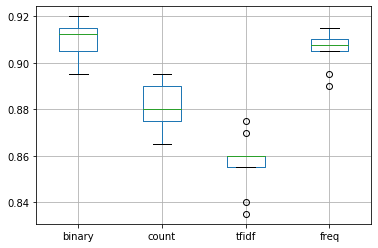

In [88]:
import matplotlib.pyplot as plt
results.boxplot()
plt.savefig('boxplot of different word scoring methods.png')
plt.show()

# Further modifications

- try to change architecture of model or hyperparameters
- try using regularizations to avoid overfitting(3rd 4th epoch is getting 1.0 training accuracy which is not good)
- try using ngrams
- try new vocab
- try data cleaning
- try ensemble

> there are endless possibilities.